## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Mounted at /content/drive


In [2]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.0 MB/s 
     |████████████████████████████████| 70 kB 7.9 MB/s 
     |████████████████████████████████| 112 kB 49.0 MB/s 
     |████████████████████████████████| 288 kB 52.8 MB/s 
     |████████████████████████████████| 1.1 MB 45.0 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 52.1 MB/s 
     |████████████████████████████████| 144 kB 70.4 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 
     |████████████████████████████████| 749 kB 52.2 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [3]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [5]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [6]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [7]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [8]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (169531, 8)


In [9]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:01:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:16:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:31:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:46:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:01:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1656017100,1656017100,20883.01,20950.00,20792.92,20815.25,858.319030,13600.0,2022-06-23 20:46:00,2022-06-23 21:00:00
1656018000,1656018000,20815.26,20852.44,20769.37,20786.46,649.720650,11949.0,2022-06-23 21:01:00,2022-06-23 21:15:00
1656018900,1656018900,20786.45,20828.23,20765.03,20817.50,277.084590,6952.0,2022-06-23 21:16:00,2022-06-23 21:30:00


### Plot wick Candles and build features from technical analysis

In [10]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:01:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:16:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:31:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:46:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:01:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-06-23 20:46:00,20792.92,20950.00,20883.01,20815.25,858.319030
2022-06-23 21:01:00,20769.37,20852.44,20815.26,20786.46,649.720650
2022-06-23 21:16:00,20765.03,20828.23,20786.45,20817.50,277.084590


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

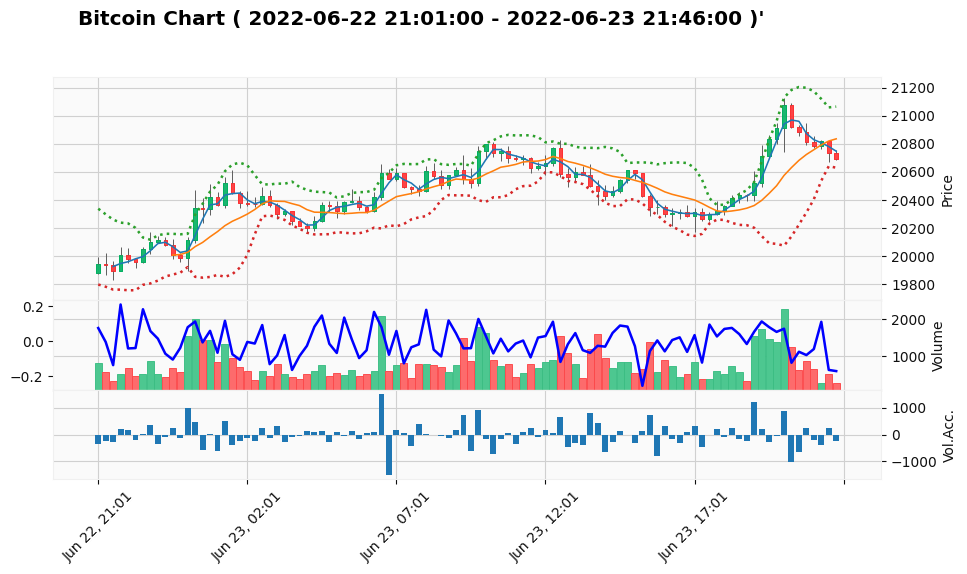

In [11]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [12]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [13]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.y[-10:]

[0.3640203402484716,
 0.36470739268789015,
 0.36621233434852485,
 0.3647961650346213,
 0.3644611063310617,
 0.36384416128342056,
 0.3635820324770217,
 0.36386464720958933,
 0.3631055753586176,
 0.3626833831824204]

## Train a CNN-LSTM model 

In [14]:
btc_model =  s2m.ModelTimeSeries(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, split_fraction = 0.9)

In [15]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 48, 32)       896         ['candles[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 48, 32)       2048        ['candles[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 48, 32)       3776        ['candles[0][0]']                
                                                                                              

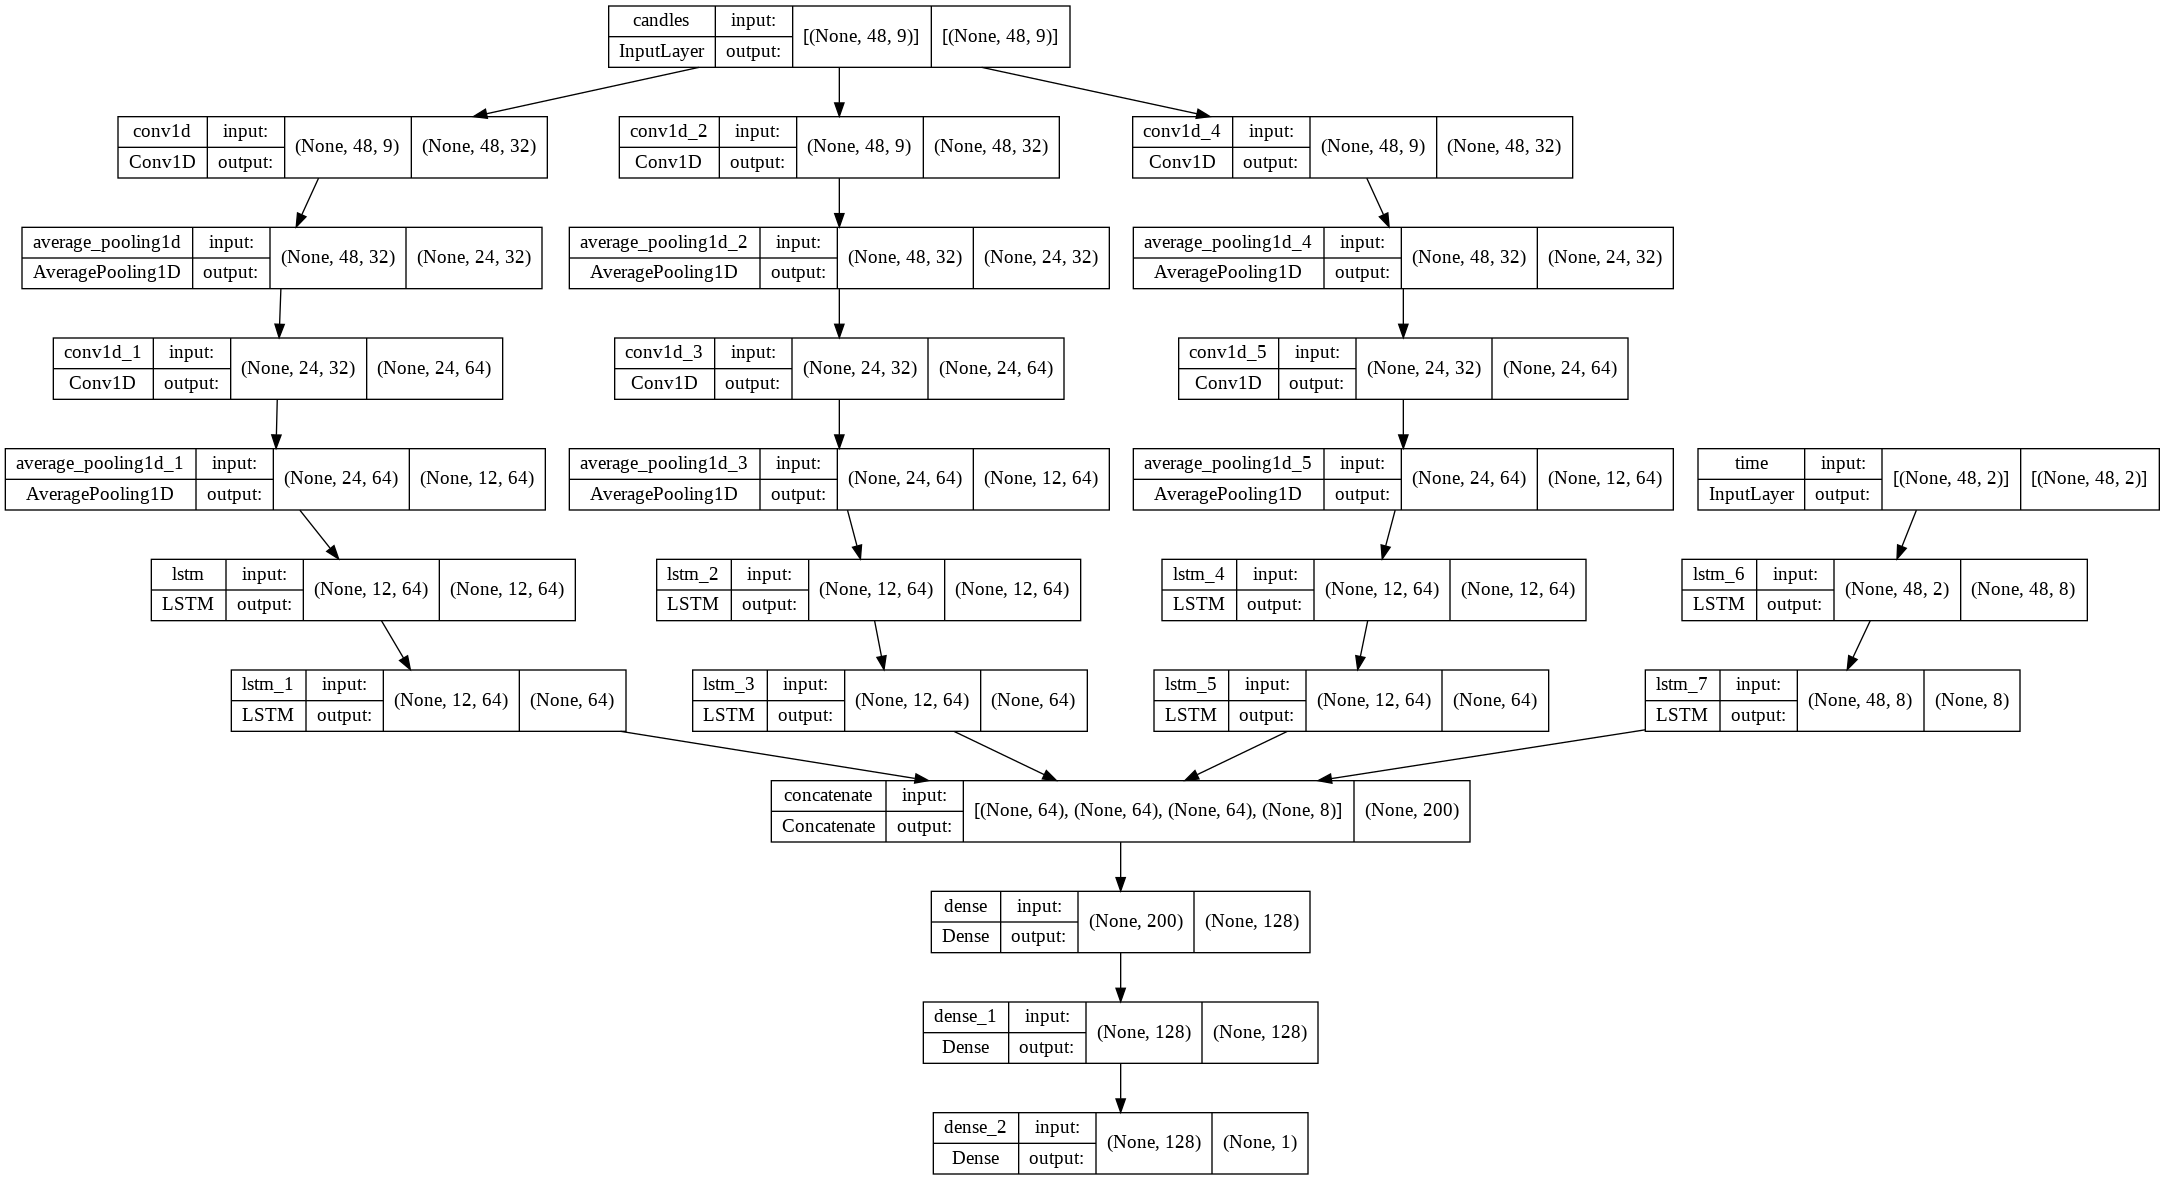

In [16]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [18]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name)

Epoch 1/20
11/11 [==============================] - 33s 714ms/step - loss: 0.2049 - val_loss: 0.1442
Epoch 2/20
11/11 [==============================] - 1s 109ms/step - loss: 0.0542 - val_loss: 0.0716
Epoch 3/20
11/11 [==============================] - 1s 112ms/step - loss: 0.0365 - val_loss: 0.0667
Epoch 4/20
11/11 [==============================] - 1s 105ms/step - loss: 0.0199 - val_loss: 0.0097
Epoch 5/20
11/11 [==============================] - 1s 91ms/step - loss: 0.0213 - val_loss: 0.0353
Epoch 6/20
11/11 [==============================] - 1s 105ms/step - loss: 0.0137 - val_loss: 0.0051
Epoch 7/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0105 - val_loss: 0.0077
Epoch 8/20
11/11 [==============================] - 1s 102ms/step - loss: 0.0101 - val_loss: 0.0045
Epoch 9/20
11/11 [==============================] - 1s 106ms/step - loss: 0.0096 - val_loss: 0.0107
Epoch 10/20
11/11 [==============================] - 1s 105ms/step - loss: 0.0094 - val_loss: 0.0053

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


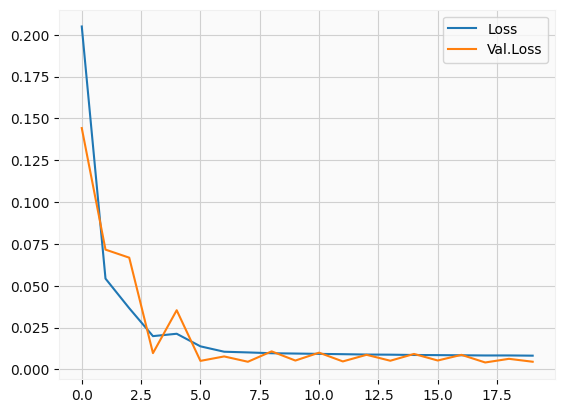

In [19]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [20]:
btc_model.sats2pred(predict_on_test = True)

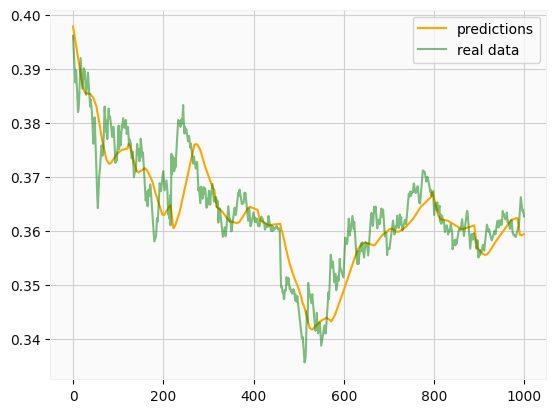

In [21]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [22]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

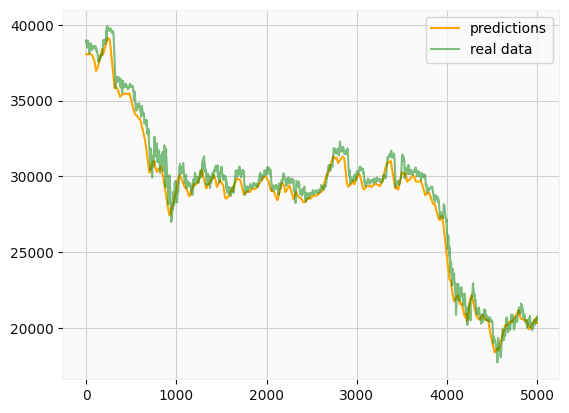

In [23]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

## Rough back-testing buy or do nothing, i.e. up-only

Fee: 0.025
----------------------
Buy      116 ( 77 ok 39 ko )
No-op    4880
Wallet   8737.588999999973
Drawback -627.4024999999986
Total earned 8737.588999999973


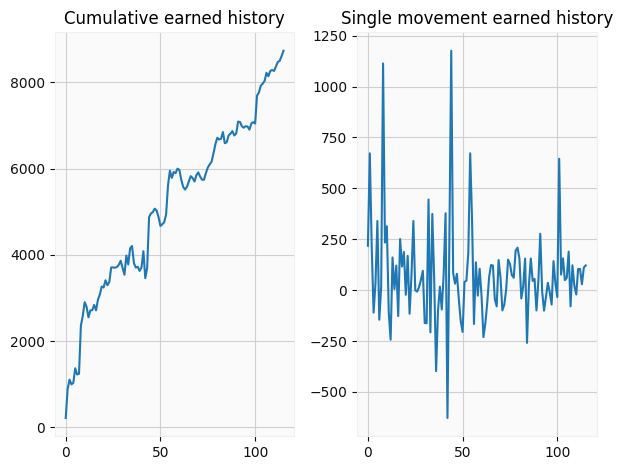

In [24]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)

print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

## Train for more epochs

In [25]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [27]:
btc_model.sats2train(model_name, epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 119ms/step - loss: 0.0081 - val_loss: 0.0075
Epoch 2/100
11/11 [==============================] - 1s 93ms/step - loss: 0.0082 - val_loss: 0.0046
Epoch 3/100
11/11 [==============================] - 1s 109ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 4/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 5/100
11/11 [==============================] - 1s 92ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 6/100
11/11 [==============================] - 1s 123ms/step - loss: 0.0077 - val_loss: 0.0052
Epoch 7/100
11/11 [==============================] - 1s 112ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 8/100
11/11 [==============================] - 1s 97ms/step - loss: 0.0079 - val_loss: 0.0038
Epoch 9/100
11/11 [==============================] - 1s 102ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 10/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0075 - val_loss:

INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


INFO:tensorflow:Assets written to: model/LSTM_CNN_model/assets


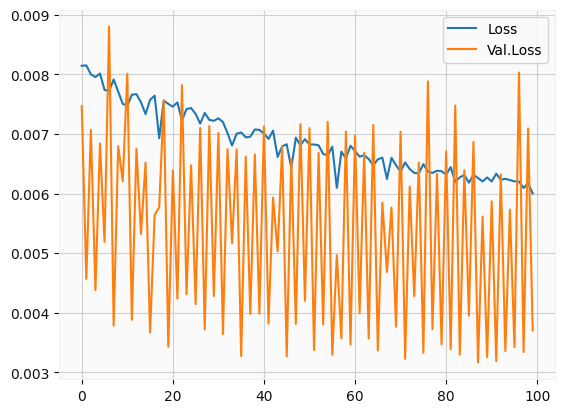

In [28]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [30]:
btc_model.sats2pred(predict_on_test = True)

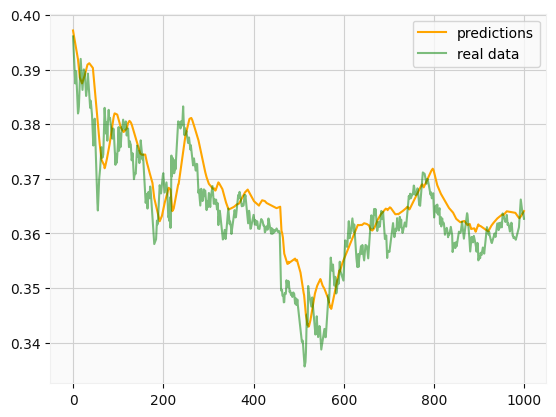

In [31]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [38]:
true_vals = ts_btc.denorm(ts_btc.candles_norm[:,-1])
preds = ts_btc.denorm(btc_model.preds)

Fee: 0.025
----------------------
Buy      395 ( 228 ok 167 ko )
No-op    4601
Wallet   10727.70949999999
Drawback -927.1227499999984
Total earned 10727.70949999999


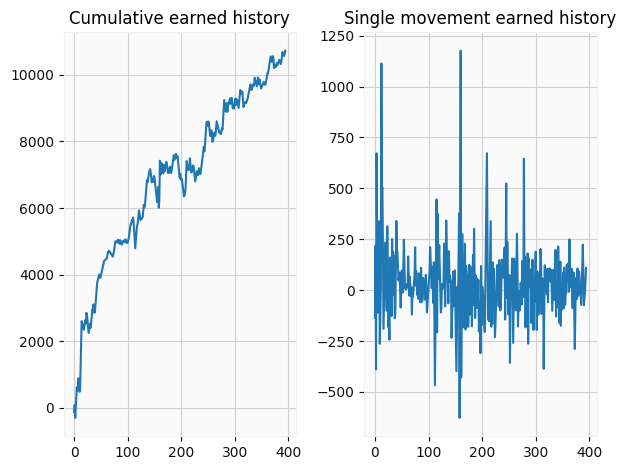

In [32]:

total_wallet_history, single_wallet_history, wallet = ts_btc.backtest(preds, true_vals, btc_model.split_point, ts_btc.step_back, fee=0.025)
print('Total earned', wallet)

plt.subplot(1, 2, 1)
plt.plot(total_wallet_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_wallet_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()

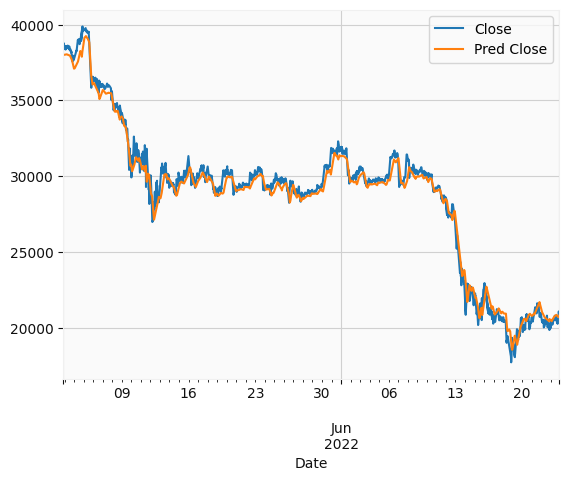

In [43]:
shifted_time_indexes = tu.shift_time_index(can_btc.candles.index,1,can_btc.dtime_index)
series_predicted = tu.arr2series(preds,"Pred Close",shifted_time_indexes,top_or_bottom="bottom")
df_preds_true = tu.mergetimeseries(can_btc.candles["Close"], series_predicted)
df_preds_true.dropna().plot()

In [35]:
import src.timeutils as tu

df_pred_exp = pd.DataFrame(np.array([preds,true_vals[-len(preds):]]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = tu.log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = tu.log_return(df_pred_exp["Predicted"],periods=-1)


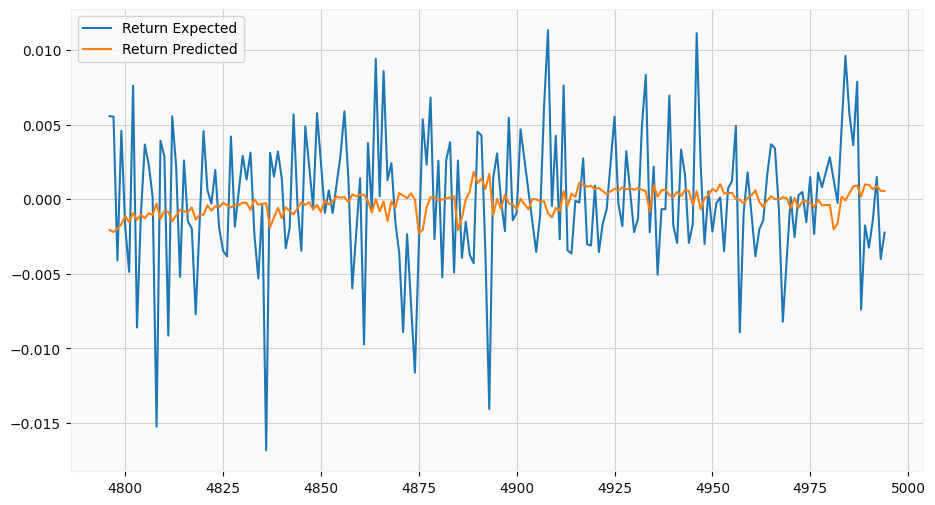

In [36]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-200:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-200:].plot(y="Return Predicted",ax=axs)